# 最適フィードバック制御モデル (optimal feedback control; OFC)

## 最適フィードバック制御モデルの構造
> Todorov, E. (2005) Stochastic optimal control and estimation methods adapted to the noise characteristics of the sensorimotor system. *Neural Computation* 17(5): 1084-1108

本節はTodorovの[MATLABコード](https://homes.cs.washington.edu/~todorov/software/gLQG.zip)を元にしている (現状ほぼJuliaへの単なる移植であることを明言しておく)．

**最適フィードバック制御モデル(optimal feedback control; OFC)** の特徴として目標軌道を必要としないことが挙げられる．**Kalman フィルタ**による状態推定と**線形2次レギュレーター(LQR: linear-quadratic regurator)** により推定された状態に基づいて運動指令を生成という2つの流れが基本となる．

### 系の状態変化

$$
\begin{aligned}
&\text {Dynamics} \quad \mathbf{x}_{t+1}=A \mathbf{x}_{t}+B \mathbf{u}_{t}+\boldsymbol{\xi}_{t}+\sum_{i=1}^{c} \varepsilon_{t}^{i} C_{i} \mathbf{u}_{t}\\
&\text {Feedback} \quad \mathbf{y}_{t}=H \mathbf{x}_{t}+\omega_{t}+\sum_{i=1}^{d} \epsilon_{t}^{i} D_{i} \mathbf{x}_{t}\\
&\text{Cost per step}\quad \mathbf{x}_{t}^\top Q_{t} \mathbf{x}_{t}+\mathbf{u}_{t}^\top R \mathbf{u}_{t}
\end{aligned}
$$

### LQG
加法ノイズしかない場合($C=D=0$)，制御問題は**線形2次ガウシアン(LQG: linear-quadratic-Gaussian)制御**と呼ばれる．


#### 運動制御 (Linear-Quadratic Regulator)

$$
\begin{align}
\mathbf{u}_{t}&=-L_{t} \widehat{\mathbf{x}}_{t}\\
L_{t}&=\left(R+B^{\top} S_{t+1} B\right)^{-1} B^{\top} S_{t+1} A\\
S_{t}&=Q_{t}+A^{\top} S_{t+1}\left(A-B L_{t}\right)\\
\end{align}
$$

#### 状態推定 (Kalman Filter)

$$
\begin{align}
\widehat{\mathbf{x}}_{t+1}&=A \widehat{\mathbf{x}}_{t}+B \mathbf{u}_{t}+K_{t}\left(\mathbf{y}_{t}-H \widehat{\mathbf{x}}_{t}\right)+\boldsymbol{\eta}_{t} \\ 
K_{t}&=A \Sigma_{t} H^{\top}\left(H \Sigma_{t} H^{\top}+\Omega^{\omega}\right)^{-1} \\ 
\Sigma_{t+1}&=\Omega^{\xi}+\left(A-K_{t} H\right) \Sigma_{t} A^{\top}
\end{align}
$$

この場合に限り，運動制御と状態推定を独立させることができる．

### 一般化LQG
状態および制御依存ノイズがある場合，

## 実装
ライブラリの読み込みと関数の定義．

In [1]:
using Base: @kwdef
using Parameters: @unpack
using LinearAlgebra, Kronecker, Random, BlockDiagonals, PyPlot
rc("axes.spines", top=false, right=false)
rc("font", family="Arial") 

In [5]:
@kwdef struct SaccadeModelParameter
    n = 4 # number of dims
    p = 3 # 
    i = 0.25 # kgm^2, 
    b = 0.2 # kgm^2/s
    ta = 0.03 # s
    te = 0.04 # s
    L0 = 0.35 # m

    bu = 1 / (ta * te * i)
    α1 = bu * b
    α2 = 1/(ta * te) + (1/ta + 1/te) * b/i
    α3 = b/i + 1/ta + 1/te

    A = [zeros(p) I(p); -[0, α1, α2, α3]']
    B = [zeros(p); bu]
    C = [I(p) zeros(p)]
    D = Diagonal([1e-3, 1e-2, 5e-2])

    Y = 0.02 * B
    G = 0.03 * I(n)

    Q = Diagonal([1.0, 0.01, 0, 0]) 
    R = 0.0001
    U = Diagonal([1.0, 0.1, 0.01, 0])
end

SaccadeModelParameter

In [6]:
param = SaccadeModelParameter();
#L, K = infinite_horizon_ofc(param);

### シミュレーション

H -> Cに置き換え
$\boldsymbol{S}_{T}=Q$

信号依存ノイズ Yが入っている場合はどうすべきか．LQGとは異なってくるので導出必要．xiのノイズがappendixの式になし．

$$
\begin{aligned}
&\mathbf{u}_{t}=-L_{t} \hat{\mathbf{x}}_{t} \\
&L_{t}=\left(B^\top S_{t+1}^{\mathbf{x}} B+R+\sum_{n} C_{n}^\top\left(S_{t+1}^{\mathbf{x}}+S_{t+1}^{\mathrm{e}}\right) C_{n}\right)^{-1} B^\top S_{t+1}^{\mathbf{x}} A \\
&S_{t}^{\mathbf{x}}=Q_{t}+A^\top S_{t+1}^{\mathbf{x}}\left(A-B L_{t}\right) ; \quad S_{T}^{\mathbf{x}}=Q_{T} \\
&S_{t}^{\mathrm{e}}=A^\top S_{t+1}^{\mathbf{x}} B L_t+\left(A-K_{t} H\right)^\top S_{t+1}^{\mathrm{e}}\left(A-K_{t} H\right) ; \quad S_{T}^{\mathrm{e}}=0
\end{aligned}
$$

$$
\begin{aligned}
\hat{\mathbf{x}}_{t+1} &=A \hat{\mathbf{x}}_{t}+B \mathbf{u}_{t}+K_{t}\left(\mathbf{y}_{t}-H \hat{\mathbf{x}}_{t}\right) \\
K_{t} &=A \Sigma_{t}^{\mathrm{e}} H^\top\left(H \Sigma_{t}^{\mathrm{e}} H^\top+\Omega^{\omega}\right)^{-1} \\
\Sigma_{t+1}^{\mathrm{e}} &=\left(A-K_{t} H\right) \Sigma_{t}^{\mathrm{e}} A^\top+\sum_{n} C_{n} L_{t} \Sigma_{t}^{\hat{x}} L_{t}^\top C_{n}^\top ; \quad \Sigma_{1}^{\mathrm{e}}=\Sigma_{1} \\
\Sigma_{t+1}^{\hat{\mathbf{x}}} &=K_{t} H \Sigma_{t}^{\mathrm{e}} A^\top+\left(A-B L_{t}\right) \Sigma_{t}^{\hat{\mathbf{x}}}\left(A-B L_{t}\right)^\top ; \quad \Sigma_{1}^{\hat{\mathbf{x}}}=\hat{\mathbf{x}}_{1} \hat{\mathbf{x}}_{1}^\top
\end{aligned}
$$

In [7]:
@unpack n, p, A, B, C, D, Y, G, Q, R, U = param;

In [8]:
Y

4-element Vector{Float64}:
  0.0
  0.0
  0.0
 66.66666666666667

In [13]:
Sˣ = 1
Sᵉ = 1
Σˣ̂ = 1 # \Sigma TAB \^x TAB \hat TAB
Σᵉ = 1

1

In [ ]:
Sˣᵉ = 

In [ ]:
L = zeros(nt-1, n) # Feedback gains
K = zeros(nt-1, n, p) # Kalman gains
Sˣ = zeros(nt, n, n)
Sᵉ = zeros(nt, n, n)
Σˣ̂ = zeros(nt, n, n) # \Sigma TAB \^x TAB \hat TAB
Σᵉ = zeros(nt, n, n)

S[end, :, :] = Q
for t in nt-1:-1:1
    L[t, :] = (R + B' * S[t+1, :, :] * B + (Sˣ[t+1, :, :] + Sᵉ[t+1, :, :])) \ B' * S[t+1, :, :] * A
    AmKC = A - K[t, :, :] * C
    AmBL = A - B * L[t, :]'
    Sˣ[t, :, :] = Q + A' * Sˣ[t+1, :, :] * AmBL
    Sᵉ[t, :, :] = A' * Sˣ[t+1, :, :] * B * L[t, :] + AmKC' * Sᵉ[t+1, :, :] * AmKC
end

for t in 1:nt-1
    K[t, :, :] = A * Σᵉ[t, :, :] * C' / (C * Σᵉ[t, :, :] * C' + D)
    AmKC = A - K[t, :, :] * C
    AmBL = A - B * L[t, :]'
    Σᵉ[t+1, :, :] = G + AmKC * Σᵉ[t, :, :] * A' + 
    Σˣ̂[t+1, :, :] = K[t, :, :] * C * Σᵉ[t, :, :] + AmBL * Σˣ̂[t, :, :] * AmBL'
end


In [15]:
function generalized_LQG(param::SaccadeModelParameter, L, K, dt=0.001, T=2.0)
    @unpack n, p, A, B, C, D, Y, G, Q, R, U = param;
    
    nt = round(Int, T/dt)
    
    A = I + A * dt
    B = B * dt
    C = C * dt
    D = sqrt(dt) * D
    G = sqrt(dt) * G
    
    L = zeros(nt-1, n) # Feedback gains
    K = zeros(nt-1, n, p) # Kalman gains
    S = zeros(nt, n, n)
    Σ = zeros(nt, n, n);

    S[end, :, :] = Q
    for t in nt-1:-1:1
        L[t, :] = (R + B' * S[t+1, :, :] * B) \ B' * S[t+1, :, :] * A
        Sˣ = 1
        Sᵉ = 1
        S[t, :, :] = Q + A' * S[t+1, :, :] * (A - B * L[t, :]')
    end

    for t in 1:nt-1
        K[t, :, :] = A * Σ[t, :, :] * C' / (C * Σ[t, :, :] * C' + D)
        Σ[t+1, :, :] = G + (A - K[t, :, :] * C) * Σ[t, :, :] * A'
    end
    return L, K
end

2

In [8]:
function LQG(param::SaccadeModelParameter, L, K, dt=0.001, T=2.0)
    @unpack n, p, A, B, C, D, Y, G, Q, R, U = param;
    
    nt = round(Int, T/dt)
    
    A = I + A * dt
    B = B * dt
    C = C * dt
    D = sqrt(dt) * D
    G = sqrt(dt) * G
    
    L = zeros(nt-1, n) # Feedback gains
    K = zeros(nt-1, n, p) # Kalman gains
    S = zeros(nt, n, n)
    Σ = zeros(nt, n, n);

    S[end, :, :] = Q
    for t in nt-1:-1:1
        L[t, :] = (R + B' * S[t+1, :, :] * B) \ B' * S[t+1, :, :] * A
        S[t, :, :] = Q + A' * S[t+1, :, :] * (A - B * L[t, :]') # ToDo: Lのtranspose導出
    end

    for t in 1:nt-1
        K[t, :, :] = A * Σ[t, :, :] * C' / (C * Σ[t, :, :] * C' + D)
        Σ[t+1, :, :] = G + (A - K[t, :, :] * C) * Σ[t, :, :] * A'
    end
    return L, K
end

In [9]:
function simulation(param::SaccadeModelParameter, L, K, dt=0.001, T=2.0, init_pos=-0.5; noisy=false)
    @unpack n, A, B, C, D, Y, G, Q, R, U = param
    nt = round(Int, T/dt)
    X = zeros(n, nt)
    u = zeros(nt)
    X[1, 1] = init_pos # m; initial position (target position is zero)

    if noisy
        sqrtdt = √dt
        X̂ = zeros(n, nt)
        X̂[1, 1] = X[1, 1]
        for t in 1:nt-1
            u[t] = -L[t, :]' * X̂[:, t]
            X[:, t+1] = X[:,t] + (A * X[:,t] + B * u[t]) * dt + sqrtdt * (Y * u[t] * randn() + G * randn(n))
            dy = C * X[:,t] * dt + D * sqrtdt * randn(n-1)
            X̂[:, t+1] = X̂[:,t] + (A * X̂[:,t] + B * u[t]) * dt + K[t, :, :] * (dy - C * X̂[:,t] * dt)
        end
    else
        for t in 1:nt-1
            u[t] = -L[t, :]' * X[:, t]
            X[:, t+1] = X[:, t] + (A * X[:, t] + B * u[t]) * dt
        end
    end
    return X, u
end

simulation (generic function with 4 methods)

理想状況でのシミュレーション

In [10]:
Xa, ua = simulation(param, L, K, dt, T, noisy=false);

### ノイズを含むシミュレーション

In [11]:
n = 4
nsim = 10
XSimAll = []
uSimAll = []
for i in 1:nsim
    XSim, u = simulation(param, L, K, dt, T, noisy=true);
    push!(XSimAll, XSim)
    push!(uSimAll, u)
end

### 結果の描画

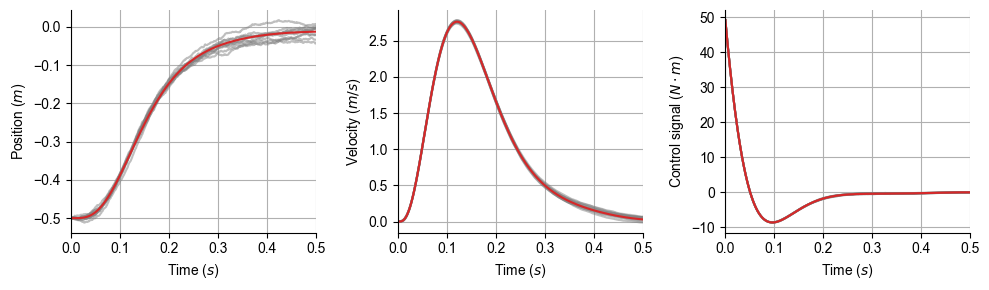

In [12]:
tarray = collect(dt:dt:T)
label = [L"Position ($m$)", L"Velocity ($m/s$)", L"Acceleration ($m/s^2$)", L"Jerk ($m/s^3$)"]

fig, ax = subplots(1, 3, figsize=(10, 3))
for i in 1:2
    for j in 1:nsim
        ax[i].plot(tarray, XSimAll[j][i,:]', "tab:gray", alpha=0.5)
    end
    
    ax[i].plot(tarray, Xa[i,:], "tab:red")
    ax[i].set_ylabel(label[i]); ax[i].set_xlabel(L"Time ($s$)"); ax[i].set_xlim(0, T); ax[i].grid()
end

for j in 1:nsim
    ax[3].plot(tarray, uSimAll[j], "tab:gray", alpha=0.5)
end
ax[3].plot(tarray, ua, "tab:red")
ax[3].set_ylabel(L"Control signal ($N\cdot m$)"); ax[3].set_xlabel(L"Time ($s$)"); ax[3].set_xlim(0, T); ax[3].grid()

tight_layout()

## 参考文献
```{bibliography}
:filter: docname in docnames
```